# Hypertropical Region Visualization

This notebook visualizes hypertropical regions based on 10 climate models.
It performs the following:
- Loads model-specific raster masks identifying hypertropical regions.
- Resamples them to a common shape.
- Overlays and counts the number of models agreeing on the same region.
- Applies a land-only mask to focus on terrestrial hypertropics.
- Plots the resulting overlay for visualization.

**Requirements**:
- `numpy`, `matplotlib`, `xarray`, `rasterio`, `cartopy`, `rioxarray`
- Input files must be placed in a specified local directory (update `base_path` accordingly).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import xarray as xr
import rioxarray
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def read_and_resample_raster(file_path, target_shape):
    with rasterio.open(file_path) as src:
        # Resample data to target shape
        data = src.read(
            out_shape=target_shape,
            resampling=Resampling.nearest
        )
        return data.squeeze()

base_path = '/Users/yanlei/Documents/PhD/postdoc_2A/Jeff_Nature/Figure4_CMIP6_datasets/'
models_sources = [
    ('MIROC', 'MIROC-ES2L'),
    ('BCC', 'BCC-CSM2-MR'),
    ('NOAA-GFDL', 'GFDL-ESM4'),
    ('MRI', 'MRI-ESM2-0'),
    ('NCC', 'NorESM2-LM'),
    ('MPI-M', 'MPI-ESM1-2-LR'), #same as future model
    ('CAMS', 'CAMS-CSM1-0'),
    ('NASA-GISS', 'GISS-E2-1-G'),
    ('NCAR', 'CESM2-WACCM'),
    ('CNRM-CERFACS', 'CNRM-CM6-1')]


## 1. Identifying hypertropical regions and processed dataset

In [7]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs

models_sources = [
    'MIROC',
    'BCC',
    'NOAA-GFDL',
    'MRI', 
    'NCC', 
    'MPI-M', 
    'CAMS',
    'NASA-GISS',
    'NCAR',
    'CNRM-CERFACS']

def read_and_resample_raster(file_path, target_shape):
    with rasterio.open(file_path) as src:
        # Resample data to target shape
        data = src.read(
            out_shape=target_shape,
            resampling=Resampling.nearest
        )
        return data.squeeze()

base_path = '/Users/yanlei/Documents/PhD/postdoc_2A/Jeff_Nature/Figure4_CMIP6_datasets/'

# Construct the file paths for the raster files
file_paths = [f'{base_path}ssp585/hyper_regions/{model}_hypertropical_regions_mask_lfp90_20yrs_upd_newHypertropics.tif' for model in models_sources]

# Determine a common shape for resampling (e.g., based on the first file)
with rasterio.open(file_paths[1]) as src:
    target_shape = (160, 320)  # Example: use the same resolution


model_short, model_full = 'BCC', 'BCC-CSM2-MR'  # Replace with actual names
mask_file = f'{base_path}sftlf/sftlf_{model_short}_{model_full}.nc'
mask_data = xr.open_dataset(mask_file)
landmask = mask_data['sftlf'] > 99

# Read and resample each raster
resampled_masks = [read_and_resample_raster(fp, target_shape) for fp in file_paths]
print(resampled_masks[0].shape)
# Combine and analyze overlaps
combined_mask = np.sum(np.array(resampled_masks) >= 1, axis=0)
# Apply the resampled land mask
land_masked_combined = combined_mask * (landmask != 0)

overlap_mask = combined_mask > 3  # More than 3 models overlap
# Adjusting the longitude values for plotting
lons, lats = np.meshgrid(np.linspace(-180, 180, target_shape[1]), np.linspace(-90, 90, target_shape[0]))


(160, 320)


## 2. Plot the figure

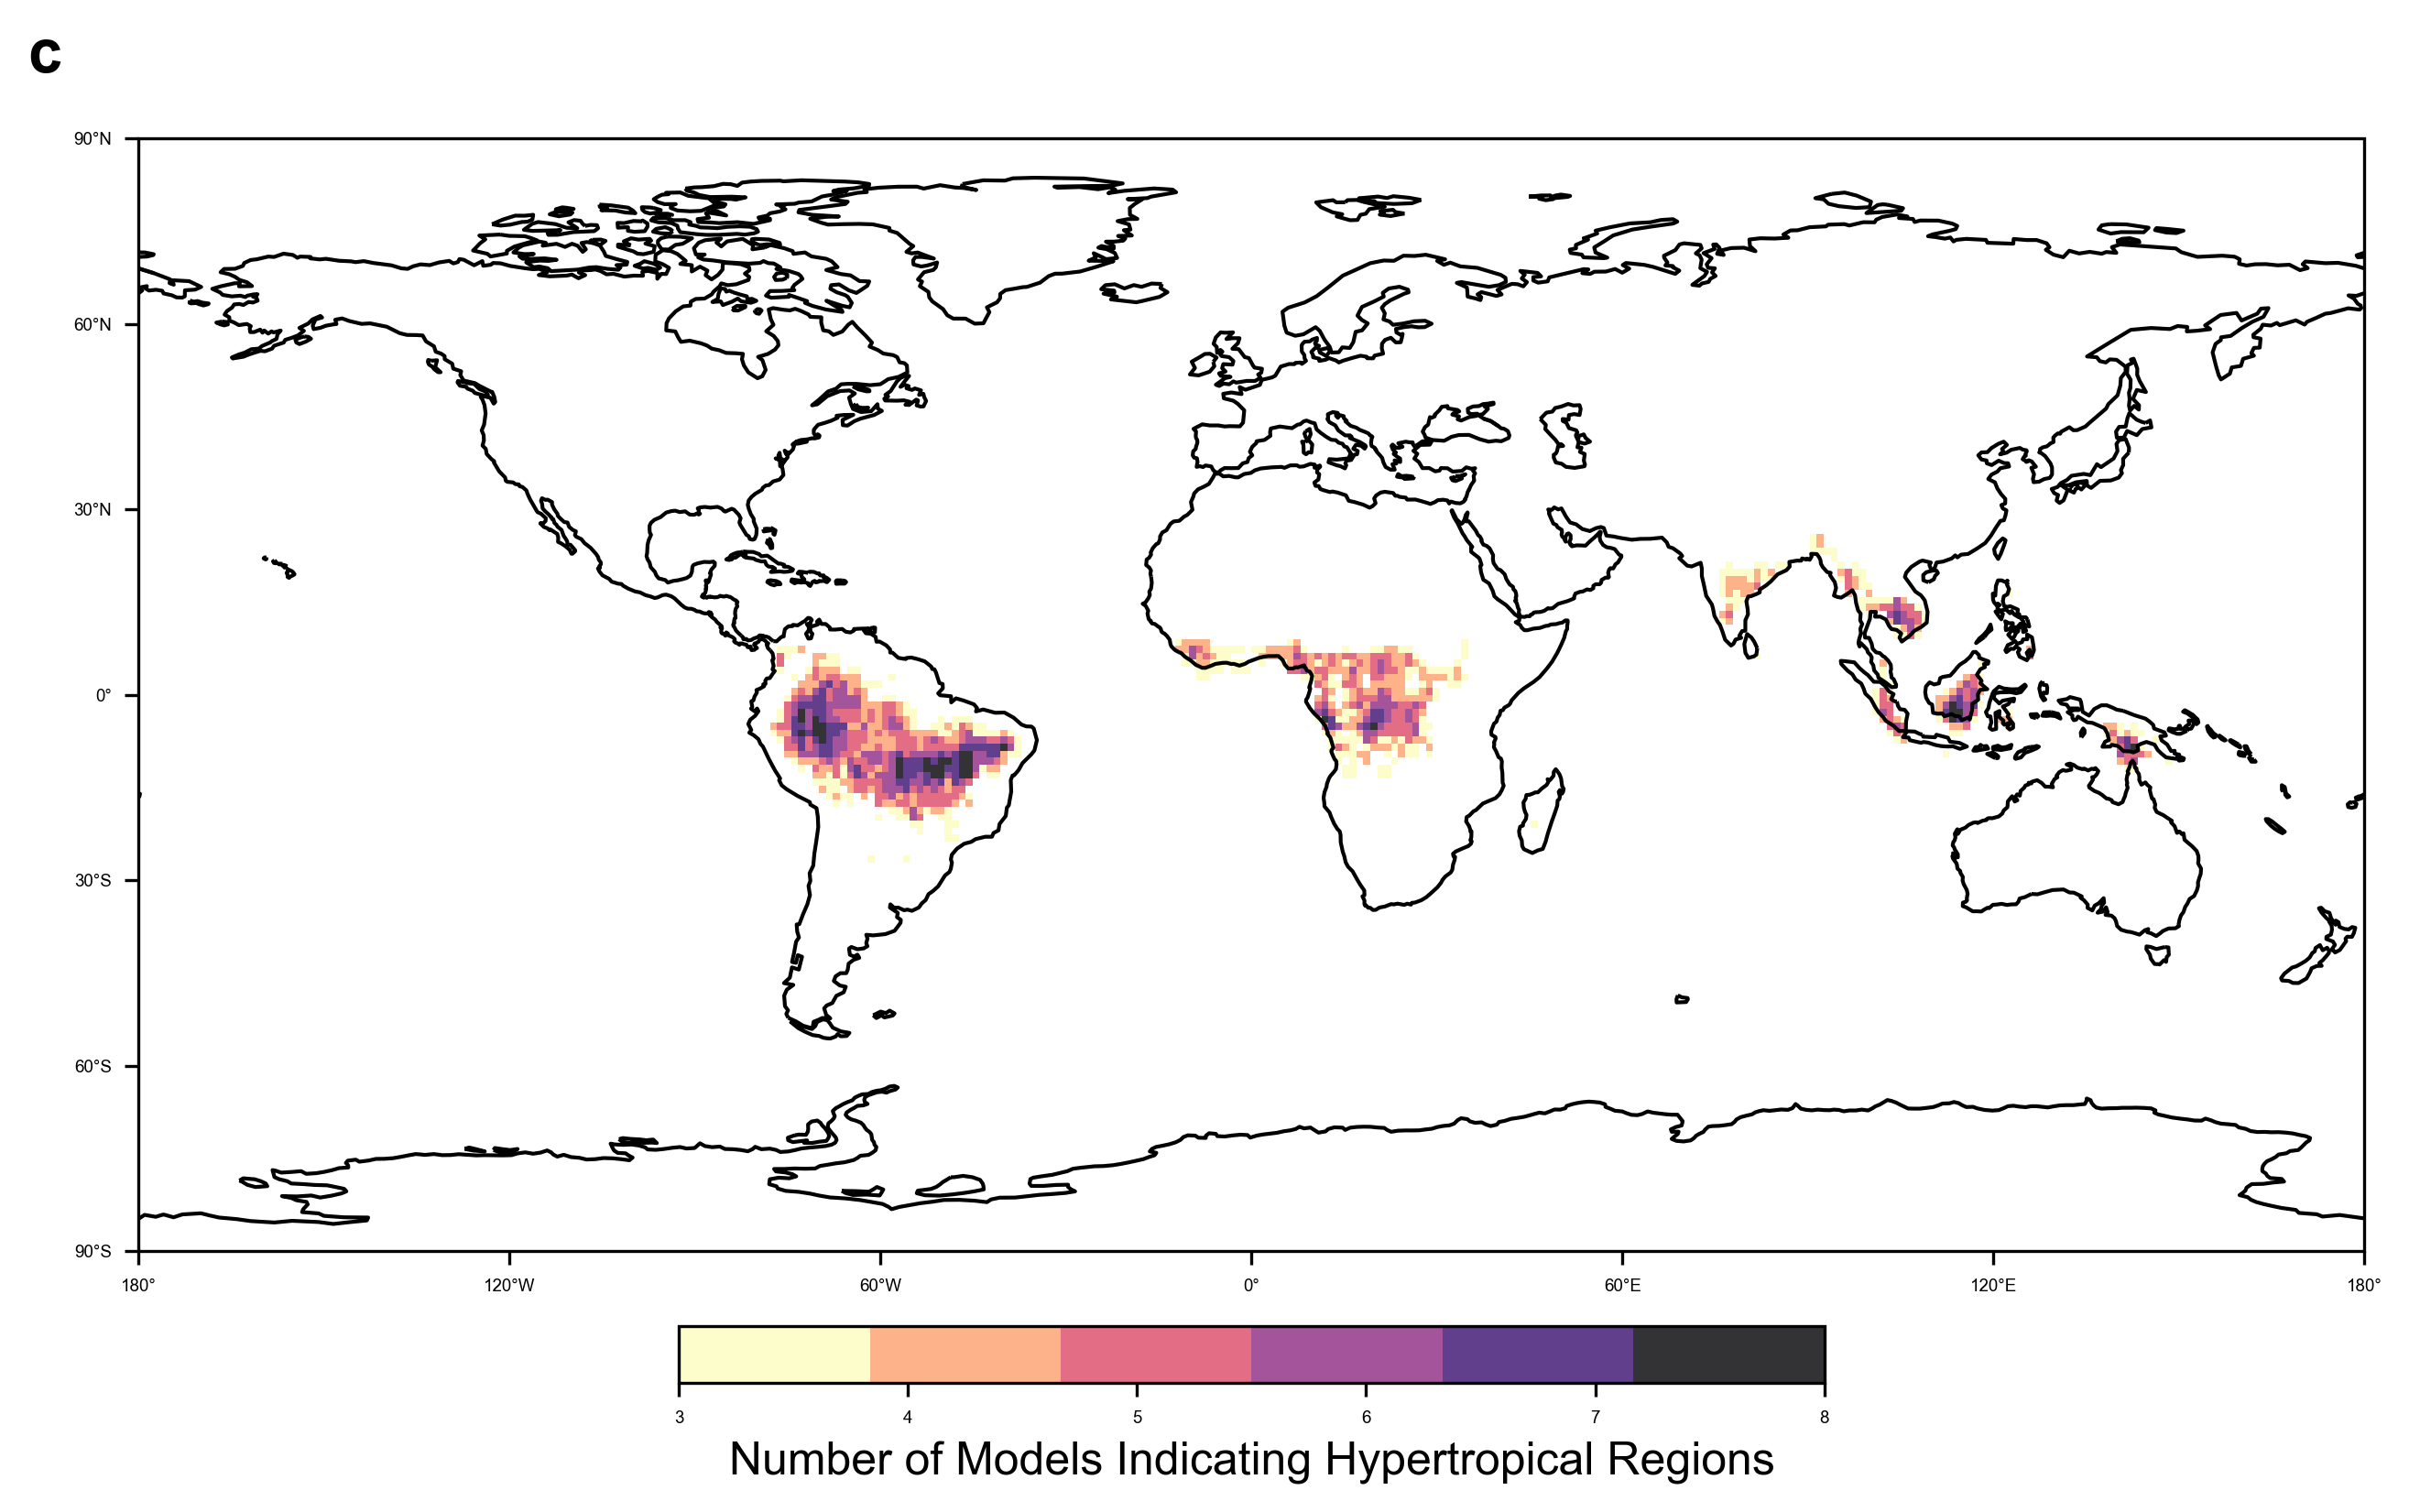

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import numpy as np
import numpy.ma as ma

# Assuming combined_mask, lons, and lats are already defined

plt.figure(figsize=(12, 6), dpi=300)  # Increased DPI for better resolution
ax = plt.axes(projection=ccrs.PlateCarree())

# Set background color to white
ax.set_facecolor('white')

# Add coastlines
ax.coastlines()
# ax.add_feature(cfeature.OCEAN) 
# ax.add_feature(cfeature.LAND)
# Set x and y ticks every 30 degrees
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())

# Format the tick labels as latitude and longitude
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# Mask the areas without hypertropical regions (values < 1)
masked_combined_mask = ma.masked_less(combined_mask, 3)

# Plot the number of models that agree on each pixel
cmap = plt.cm.get_cmap('magma_r', 
                       np.max(masked_combined_mask) - np.min(masked_combined_mask) + 1)
mesh = ax.pcolormesh(lons, lats, masked_combined_mask, 
                     transform=ccrs.PlateCarree(), cmap=cmap, alpha=0.8)

# Add a colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', fraction=0.046, pad=0.06)
cbar.set_label('Number of Models Indicating Hypertropical Regions', fontsize=12)
plt.gca().text(-0.05, 1.1, 'c', transform=plt.gca().transAxes,
               fontsize=16, fontname='Arial', fontweight='bold', va='top', ha='left')
plt.show()


## 3. Make the figure following Nature settings

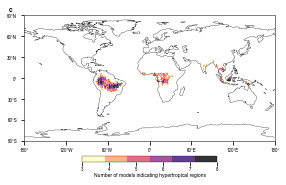

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import numpy as np
import numpy.ma as ma

# Nature-style settings
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 6.0,
    'axes.labelsize': 6.0,
    'xtick.labelsize': 4.5,
    'ytick.labelsize': 4.5,
    'pdf.fonttype': 42
})

fig = plt.figure(figsize=(7.2, 2.7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('white')
ax.coastlines(linewidth=0.3)

# Tick config
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# Lighten axis frame
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_edgecolor('black')

# Data plotting
masked_combined_mask = ma.masked_less(combined_mask, 3)
cmap = plt.cm.get_cmap('magma_r', 
                       np.max(masked_combined_mask) - np.min(masked_combined_mask) + 1)
mesh = ax.pcolormesh(lons, lats, masked_combined_mask, 
                     transform=ccrs.PlateCarree(), cmap=cmap, alpha=0.8)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)
# cbar.set_label('Number of Models Indicating Hypertropical Regions', fontsize=5, labelpad=1)
cbar.set_label('Number of models indicating hypertropical regions', fontsize=5, labelpad=1)

cbar.ax.tick_params(labelsize=4.5, pad=1)

# Make colorbar frame thin and clean
cbar.outline.set_linewidth(0.3)
cbar.outline.set_edgecolor('black')  # or use 'gray' for extra softness

# Panel label
ax.text(-0.06, 1.07, 'c', transform=ax.transAxes,
        fontsize=6.5, fontweight='bold', fontname='Arial', va='top', ha='left')

# Save
# fig_path_c = "Figure4c.jpg"
# plt.savefig(fig_path_c, dpi=300, bbox_inches='tight')
plt.show()
